# Non-equilibrium forces decomposition of two species ecosystem

![2DForces](/home/jose/MEGA/PersonalWebPages/imagenes/2D_Forces.png "Forces decomposition")

## Introduction 

Understanding the ecological forces that shapes microbial communities is a fundamental problem in ecology. 




In [62]:
def A(x1, x2,c12,c21,tau1,tau2,K1,K2):
    
    '''
    Function that returns the 2D Lotka-Volterra drift
    '''
    
    c11=-1/(tau1*K1)
    c22=-1/(tau2*K2)
    
    N1=x1.size
    N2=x2.size
    
    v1=np.zeros([N1,N2])    
    v2=np.zeros([N1,N2])  
    
    v1=  np.array( (x1)*(1/tau1+c11*x1) ).reshape(-1,1) + (c12/tau1)*np.tensordot(x1,x2,axes=0)
    v2=  np.array( (x2)*(1/tau2+c22*x2) ) + (c21/tau2)*np.tensordot(x2,x1,axes=0)
    
    drift=[v1,v2]
    
    return drift

## Friction Force


In [63]:
def FrictionForce(x1,x2,tau1,tau2,s,sigmaNoise1,sigmaNoise2,N1,N2):
    
    gamma11=sigmaNoise1/tau1
    gamma12=np.sqrt(sigmaNoise1/tau1)*np.sqrt(sigmaNoise2/tau2)*s
    gamma22=sigmaNoise2/tau2
    
    ff1=np.zeros([N1,N2])
    ff2=np.zeros([N1,N2])
    
    ff1=0.5*(2.0*gamma11*x1.reshape(-1,1)+gamma12*np.tensordot(x1,x2,axes=0))
    ff2=0.5*(2.0*gamma22*x2+gamma12*np.tensordot(x1,x2,axes=0))
    
    return [ff1,ff2]

## Gradient Force

$$ \boldsymbol{D} \nabla log(P)=
\begin{pmatrix}
D_{11} & D_{12} \\
D_{21} & D_{22}
\end{pmatrix}
\cdot
\begin{pmatrix}
\partial_{x} log(P) \\
\partial_{y} log(P)
\end{pmatrix}
$$

In [64]:
def GradientForce(P,tau1,tau2,s,sigmaNoise1,sigmaNoise2,h,N1,N2,left_border):
    
    gamma11=sigmaNoise1/tau1
    gamma12=np.sqrt(sigmaNoise1/tau1)*np.sqrt(sigmaNoise2/tau2)*s
    gamma22=sigmaNoise2/tau2
    
    VF1=np.zeros([N1,N2])
    VF2=np.zeros([N1,N2])
    
    x2=left_border
    
    for j in range(1,N2-1):
    
    	x2=x2+h
    	x1=left_border
    	for i in range(1,N1-1):
           x1=x1+h
           #Conservative force
           # if(P[i][j]>1e-4):
           VF1[i][j]=0.5*(gamma11*x1*x1*(P[i+1][j]-P[i-1][j])/(2.0*h)+gamma12*x1*x2*(P[i][j+1]-P[i][j-1])/(2.0*h))/(P[i][j])
           VF2[i][j]=0.5*(gamma12*x1*x2*(P[i+1][j]-P[i-1][j])/(2.0*h)+gamma22*x2*x2*(P[i][j+1]-P[i][j-1])/(2.0*h))/(P[i][j])
                
                
    return [VF1,VF2]

## Curl Force


In [65]:
def CURL(P,v1,v2,tau1,tau2,s,sigmaNoise1,sigmaNoise2,h,N1,N2,left_border):
    
    '''
    Function that returns the 2D CURL FORCE: J/P
    -J Probability Density Current
    -P Probability Density Function
    '''
    
    J1=np.zeros([N1,N2])
    J2=np.zeros([N1,N2])
    
    gamma11=sigmaNoise1/tau1
    gamma12=np.sqrt(sigmaNoise1/tau1)*np.sqrt(sigmaNoise2/tau2)*s
    gamma22=sigmaNoise2/tau2
    
    x2=left_border
    for j in range(1,N2-1):
        
        x1=left_border
        x2=x2+h
        for i in range(1,N1-1):
            
                x1=x1+h
                
                drift1=v1[i][j]*P[i][j]
                noise11=( (x1+h)*(x1+h)*P[i+1][j]-(x1-h)*(x1-h)*P[i-1][j] ) / (2.0*h)
                noise12=( (x2+h)*P[i][j+1]-(x2-h)*P[i][j-1]) / (2.0*h)
                
                J1[i][j]=(drift1-0.5*gamma11*noise11-0.5*gamma12*x1*noise12)
            
            
                drift2=v2[i][j]*P[i][j]
                noise21=( (x1+h)*P[i+1][j]-(x1-h)*P[i-1][j] ) / (2.0*h)
                noise22=( (x2+h)*(x2+h)*P[i][j+1]-(x2-h)*(x2-h)*P[i][j-1]) / (2.0*h)
            
                J2[i][j]=(drift2-0.5*gamma12*x2*noise21-0.5*gamma22*noise22)
            
           
    current=np.array([J1,J2])
    
    return current

## Plot

First let us start by importing the libraries:

In [66]:
##############################
#        LIBRARIES           #
############################## 
import numpy as np
import math as mt
import pandas as pd
import os
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import nums_from_string

The data of $P(x,y)$ is saved in *MainFolder*. This folder contains a folder with the values of the paremeters used during the simulation:

In [67]:
#Main Folder
MainFolder="/home/jose/MEGA/EcologicalForces/2D_CURRENTS/P-data"

Parameters_Folders=os.listdir(MainFolder)

Folder_num=1 #in my case is the element 1 in the folder

print(Parameters_Folders[Folder_num])

muNoise_0_sigmaNoise_0.3_tau_1_K_1


Now we can extract the paramters used in the simulation from the name of the folder:

In [68]:
##############################
#        PARAMETERS          #
##############################

Parameters=np.array(nums_from_string.get_nums(Parameters_Folders[Folder_num]))

muNoise=Parameters[0] #mean of the Gaussian white noise
sigmaNoise=Parameters[1] #standart deviation of the Gaussian white noise
tau=Parameters[2] #dynamics scale
K=Parameters[3] #maximum carrying capacity

interaction_files=os.listdir(MainFolder+"/"+Parameters_Folders[Folder_num])

file_num=1

interactions=np.array(nums_from_string.get_nums(interaction_files[file_num]))

s=interactions[0] #resources fluctuation
c12=interactions[1] #interaction 1->2
c21=interactions[2] #interaction 2->1
K1=1
K2=1

#Ito vs Stratonovich
alpha=0.5
H1=(alpha-0.5)*sigmaNoise+1.0
H2=(alpha-0.5)*sigmaNoise+1.0

#fixed point
x1star=(H1*K1*K2*c12+H2*K1)/(1-K1*K2*c12*c21)
x2star=(H2*K1*K2*c21+H1*K2)/(1-K1*K2*c12*c21)

Data load:

In [69]:
####################################
#            READ DATA             #
####################################

#read data file
f=np.loadtxt(MainFolder+"/"+Parameters_Folders[Folder_num]+"/"+interaction_files[file_num])

N=int(len(np.unique(f[:,0])))
right_border=np.round(f[N-1,0])
left_border=f[0,0]
h=(right_border-left_border)/(1.0*N);



The resulting data is *long-format* we need to convert to *wide-format* (matrix-like:), for this I propose following dummy code:

In [70]:
#Declare Probability Density Function
P=np.empty([N,N],float)

#save P data in a matrix
k=0
maxP=0.0
xPmax=0.0
yPmax=0.0
norm=0.0
for j in range(0,N):

	for i in range(0,N):
	
		P[i][j]=abs(f[k][2])
		norm=norm+P[i][j]*h*h
		k=k+1
		if(maxP<P[i][j]):
			maxP=P[i][j]
			xPmax=f[k][0]
			yPmax=f[k][1]

Plot:

/tmp/ipykernel_76619/758981523.py:20: RuntimeWarning: invalid value encountered in double_scalars
  VF1[i][j]=0.5*(gamma11*x1*x1*(P[i+1][j]-P[i-1][j])/(2.0*h)+gamma12*x1*x2*(P[i][j+1]-P[i][j-1])/(2.0*h))/(P[i][j])
/tmp/ipykernel_76619/758981523.py:21: RuntimeWarning: invalid value encountered in double_scalars
  VF2[i][j]=0.5*(gamma12*x1*x2*(P[i+1][j]-P[i-1][j])/(2.0*h)+gamma22*x2*x2*(P[i][j+1]-P[i][j-1])/(2.0*h))/(P[i][j])
/tmp/ipykernel_76619/758981523.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  VF2[i][j]=0.5*(gamma12*x1*x2*(P[i+1][j]-P[i-1][j])/(2.0*h)+gamma22*x2*x2*(P[i][j+1]-P[i][j-1])/(2.0*h))/(P[i][j])
/tmp/ipykernel_76619/758981523.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  VF1[i][j]=0.5*(gamma11*x1*x1*(P[i+1][j]-P[i-1][j])/(2.0*h)+gamma12*x1*x2*(P[i][j+1]-P[i][j-1])/(2.0*h))/(P[i][j])


Text(0.4, 2.6, '$d)$')

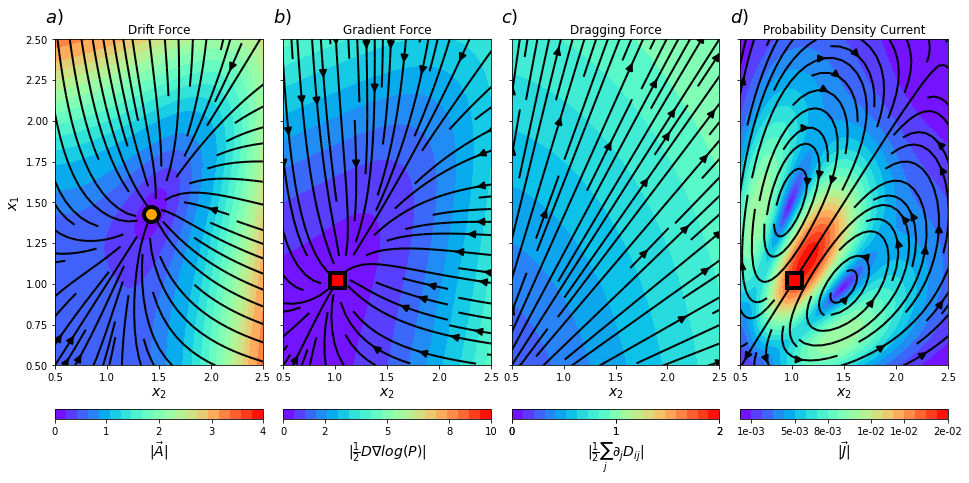

In [71]:
####################################
#            PLOT GRID             #
####################################

nrow=1
ncol=4

fig, axs = plt.subplots(nrow, ncol,sharex=True,sharey=True,figsize=(16,8))


fig.subplots_adjust(wspace=0.1, hspace=0.1)

#CREATE GRID
y,x = np.meshgrid(np.linspace(h,right_border,N),np.linspace(h,right_border,N))


################
#ABUNDANCE GRID#
################

x1=np.arange(left_border,right_border,h,dtype="double")
x2=np.arange(left_border,right_border,h,dtype="double")

#######
#DRIFT#
#######
ax1=axs[0]

#DRIFT
[A1,A2]=A(x1,x2,c12,c21,tau,tau,K,K)

#Module
module_DRIFT=np.sqrt(A1*A1+A2*A2)

#Stream plot
strm1=ax1.streamplot(y, x, A2,A1,linewidth=2, color="black", density=1.5, arrowsize=1.5)

#Plot module as a color map in the background
ticks = np.round( np.linspace(module_DRIFT.min(),4, 5, endpoint=True),0 )
Levels = np.round( np.linspace(module_DRIFT.min(),4, 20, endpoint=True),1 )
pcm1=ax1.contourf(y[0:350,0:350], x[0:350,0:350], module_DRIFT[0:350,0:350],levels=Levels,cmap="rainbow")
cbar1=fig.colorbar(pcm1, ax=ax1,orientation="horizontal",ticks=ticks,pad=0.1)
cbar1.set_label(label=r'$|\vec{A}|$',fontsize=14,fontname="Roboto")
#Plot fixed point
ax1.plot(x2star,x1star,'o', markersize=15,color="orange", markeredgewidth=4,markeredgecolor="black")

#Plot fixed points
ax1.set_xlim(0.5,2.5)
ax1.set_ylim(0.5,2.5)

ax1.title.set_text("Drift Force")
ax1.set_xlabel(r'$x_{2}$',fontsize=14,fontname="Roboto",color="black")
ax1.set_ylabel(r'$x_{1}$',fontsize=14,fontname="Roboto",color="black")
ax1.text(0.4,2.6,r"$a)$",fontsize=18,fontname="Roboto",color="black")

################
#GRADIENT FORCE#
################
ax2=axs[1]

[GF1,GF2]=GradientForce(P,tau,tau,s,sigmaNoise,sigmaNoise,h,N,N,left_border)

#REMOVE ANOMALIES: NaN & inf
GF1[np.isnan(GF1)==True]=0
GF1[np.isinf(GF1)==True]=0
GF2[np.isnan(GF2)==True]=0
GF2[np.isinf(GF2)==True]=0
#REMOVE NUMERICAL INFINITIES
GF1[abs(GF1)>6]=0
GF2[abs(GF2)>6]=0

#Module
module_GF=np.sqrt(GF1*GF1+GF2*GF2)

#Stream plot
strm2=ax2.streamplot(y, x, GF2, GF1,linewidth=2, color="black", density=1.5, arrowsize=1.5)

#Plot module as a color map in the background
ticks = np.round( np.linspace(module_GF.min(),10, 5, endpoint=True) , 0)
Levels = np.round( np.linspace(module_GF.min(),10, 20, endpoint=True) , 1)
pcm2=ax2.contourf(y[0:350,0:350], x[0:350,0:350], module_GF[0:350,0:350],levels=Levels,cmap="rainbow")
cbar2=fig.colorbar(pcm2, ax=ax2,orientation="horizontal",ticks=ticks,pad=0.1)
cbar2.set_label(label=r'$|\frac{1}{2}D\nabla log \left(P\right)|$',fontsize=14,fontname="Roboto")

#Plot maximum probability
ax2.plot(yPmax,xPmax,'s', markersize=15,color="red",markeredgewidth=4,markeredgecolor="black")

#Plot fixed points
ax2.set_xlim(0.5,2.5)
ax2.set_ylim(0.5,2.5)

ax2.title.set_text("Gradient Force")
ax2.set_xlabel(r'$x_{2}$',fontsize=14,fontname="Roboto",color="black")
ax2.text(0.4,2.6,r"$b)$",fontsize=18,fontname="Roboto",color="black")
###############
#DRAGGIN FORCE#
###############

ax3=axs[2]

[ff1,ff2]=FrictionForce(x1,x2,tau,tau,s,sigmaNoise,sigmaNoise,N,N)

#Module
module_ff=np.sqrt(ff1*ff1+ff2*ff2)

#CONVECTIVE FIELD
#[C1,C2]=[A1-ff1,A2-ff2]

#Stream plot
strm3=ax3.streamplot(y, x, ff2, ff1,linewidth=2, color="black", density=1.5, arrowsize=1.5)

#Plot module as a color map in the background
ticks = np.round( np.linspace(module_ff.min(),2, 6, endpoint=True) , 0)
Levels = np.round( np.linspace(module_ff.min(),2, 20, endpoint=True) , 1)
pcm3=ax3.contourf(y[0:350,0:350], x[0:350,0:350], module_ff[0:350,0:350],levels=Levels,cmap="rainbow")
cbar3=fig.colorbar(pcm3, ax=ax3,orientation="horizontal",ticks=ticks,pad=0.1)
cbar3.set_label(label=r'$|\frac{1}{2}\sum_j \partial_j D_{ij}|$',fontsize=14,fontname="Roboto")
#Plot fixed points
#Plot fixed point
#ax3.plot(x2star,x1star,'bo', markersize=15,color="red", markeredgewidth=4,markeredgecolor="black")

ax3.set_xlim(0.5,2.5)
ax3.set_ylim(0.5,2.5)
ax3.title.set_text("Dragging Force")
ax3.set_xlabel(r'$x_{2}$',fontsize=14,fontname="Roboto",color="black")
ax3.text(0.4,2.6,r"$c)$",fontsize=18,fontname="Roboto",color="black")
############
#CURL FORCE#
############
ax4=axs[3]

[CURL1,CURL2]=CURL(P,A1,A2,tau,tau,s,sigmaNoise,sigmaNoise,h,N,N,left_border)

#REMOVE ANOMALIES: NaN & inf
CURL1[np.isnan(CURL1)==True]=0
CURL1[np.isinf(CURL1)==True]=0
CURL2[np.isnan(CURL2)==True]=0
CURL2[np.isinf(CURL2)==True]=0
#REMOVE NUMERICAL INFINITIES
CURL1[abs(CURL1)>0.3]=0
CURL2[abs(CURL2)>0.3]=0

#Module
module_CURL=np.sqrt(CURL1*CURL1+CURL2*CURL2)

#Stream plot
strm4=ax4.streamplot(y, x, CURL2, CURL1,linewidth=2, color="black", density=1.5, arrowsize=1.5)

#Plot module as a color map in the background
ticks = np.round( np.linspace(1e-3,module_CURL.max(), 6, endpoint=True), 3 )
Levels = np.round( np.linspace(module_CURL.min(),module_CURL.max(), 20, endpoint=True), 3 )
pcm4=ax4.contourf(y[0:350,0:350], x[0:350,0:350], module_CURL[0:350,0:350],levels=Levels,cmap="rainbow")
cbar4=fig.colorbar(pcm4, ax=ax4,orientation="horizontal",ticks=ticks,pad=0.1,format='%.e')
cbar4.set_label(label=r'$|\vec{J}|$',fontsize=14,fontname="Roboto")
#Plot maximum probability
ax4.plot(yPmax,xPmax,'s', markersize=15,color="red",markeredgewidth=4,markeredgecolor="black")

#Plot fixed points
ax4.set_xlim(0.5,2.5)
ax4.set_ylim(0.5,2.5)

ax4.title.set_text("Probability Density Current")
ax4.set_xlabel(r'$x_{2}$',fontsize=14,fontname="Roboto",color="black")
ax4.text(0.4,2.6,r"$d)$",fontsize=18,fontname="Roboto",color="black")
